References:
- https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
# Igone this upload
!export WANDB_IGNORE_GLOBS=*.h5

In [20]:
# Imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import matplotlib.pyplot as plt
%matplotlib inline

import time


import tensorflow as tf
print(tf.__version__)

2.1.0


In [11]:
# Let TensorFlow take care of parallelism
AUTO = tf.data.experimental.AUTOTUNE

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
# Available datasets
tfds.list_builders()[:10]

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist']

In [ ]:
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

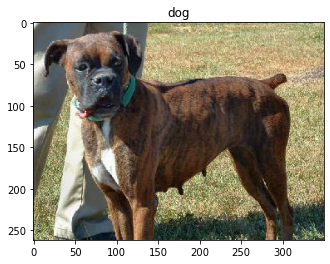

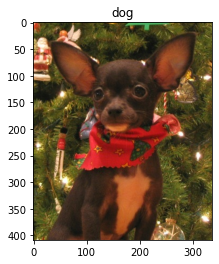

In [7]:
# Show two image from the train set
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [8]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [13]:
# Preprocess the images
train = raw_train.map(format_example)
valid = raw_validation.map(format_example)

In [14]:
# Prepare batches of 32 and randomly shuffle the training images
train_batches = train.shuffle(1024).repeat().batch(32).prefetch(AUTO)
valid_batches = valid.repeat().batch(32).prefetch(AUTO)

In [15]:
# Inspect the shapes
for (images, labels) in train_batches.take(1):
    pass
print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [16]:
# Load the MobileNetV2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

In [17]:
def get_training_model():
    # Fine-tune
    EXTRACTOR.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(1)(class_head)

    # Create the new model
    pet_classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)
    
    # Compile and return the model
    pet_classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                          optimizer="adam",
                          metrics=["accuracy"])
    
    return pet_classifier

In [18]:
# # Set up wandb
# ##############

import wandb
from wandb.keras import WandbCallback

wandb.init(project="tensorflow-multi-gpu-dist", id="1-gpu-ft")

W&B Run: https://app.wandb.ai/sayakpaul/tensorflow-multi-gpu-dist/runs/1-gpu-ft

In [19]:
# Class labels
LABELS = ["cat", "dog"]

In [21]:
# Train the model
start = time.time()
model = get_training_model()
model.fit(train_batches,
    steps_per_epoch=582,
    validation_data=valid_batches,
    validation_steps=146,
    epochs=10,
    callbacks=[WandbCallback(data_type="image", labels=LABELS)])
end = time.time() - start
print("model training time", end)
wandb.log({"training_time":end})

Train for 582 steps, validate for 146 steps
Epoch 1/10
582/582 [==============================] - 220s 377ms/step - loss: 0.1374 - accuracy: 0.9423 - val_loss: 2.1638 - val_accuracy: 0.8408
Epoch 2/10
582/582 [==============================] - 207s 355ms/step - loss: 0.0924 - accuracy: 0.9644 - val_loss: 2.8143 - val_accuracy: 0.8106
Epoch 3/10
582/582 [==============================] - 207s 356ms/step - loss: 0.0869 - accuracy: 0.9651 - val_loss: 7.9089 - val_accuracy: 0.6201
Epoch 4/10
582/582 [==============================] - 207s 356ms/step - loss: 0.0645 - accuracy: 0.9759 - val_loss: 0.6378 - val_accuracy: 0.9204
Epoch 5/10
582/582 [==============================] - 208s 358ms/step - loss: 0.0544 - accuracy: 0.9790 - val_loss: 0.5642 - val_accuracy: 0.9253
Epoch 6/10
582/582 [==============================] - 207s 355ms/step - loss: 0.0523 - accuracy: 0.9800 - val_loss: 1.2637 - val_accuracy: 0.8718
Epoch 7/10
582/582 [==============================] - 209s 359ms/step - loss: 0.

When fine-tuning networks, it's a good practice to use a learning rate schedule with ramp-up. The idea here is to start with a low learning rate so that the pre-trained weights of the base network do not get broken. We then increase the learning rate and decrease it again. The schedule would look like so - 

In [24]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [22]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 2.6384000000000004e-05


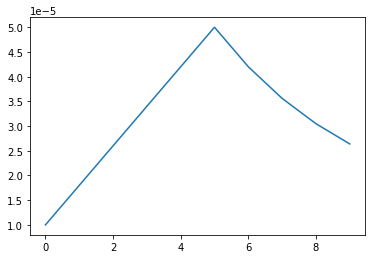

In [25]:
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [26]:
# Reinitialize wandb
wandb.init(project="tensorflow-multi-gpu-dist", id="1-gpu-ft-lrs")

# Train the network
start = time.time()
model = get_training_model()
model.fit(train_batches,
    steps_per_epoch=582,
    validation_data=valid_batches,
    validation_steps=146,
    epochs=10,
    callbacks=[WandbCallback(data_type="image", labels=LABELS),
              lr_callback])
end = time.time() - start
print("model training time", end)
wandb.log({"training_time":end})

Train for 582 steps, validate for 146 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
582/582 [==============================] - 215s 369ms/step - loss: 0.1754 - accuracy: 0.9082 - val_loss: 0.0689 - val_accuracy: 0.9655

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
582/582 [==============================] - 207s 355ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0516 - val_accuracy: 0.9730

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
582/582 [==============================] - 208s 357ms/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.0484 - val_accuracy: 0.9784

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
582/582 [==============================] - 206s 355ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0542 - val_accuracy: 0.9803

Epoch 00005: LearningRateScheduler reducing 